In [1]:
import numpy as np
import dynet_config
dynet_config.set(
    mem=4096,
    autobatch=True,      # utilize autobatching
    random_seed=1978     # simply for reproducibility here
)
import dynet as dy
from os import path

# `dyNet` example: `pos` tagging

In [2]:
dy.__version__

2.0

## import features

In [3]:
import sys
sys.path.append("..")
import utils as u

In [4]:
# change this string to match the path on your computer
path_to_root = "/Users/mcapizzi/Github/dynet_tutorial/"

In [5]:
train_tokens, train_labels, _, _, test_tokens, test_labels = u.import_pos(path_to_root)

loading training data
parsed 72914 sentences
loading dev data
parsed 7859 sentences
loading test data
parsed 2493 sentences


The training data consists of a `<list>` of `<list>` of tokens, and the labels are a `<list>` of `<list>` `pos` tags where each individual `<list>` is a training instance to be fed through the `RNN`.

In [6]:
train_tokens[0][:5], train_labels[0][:5]

(['for', 'six', 'years', ',', 't.'], ['IN', 'CD', 'NNS', ',', 'NNP'])

We also need to build a map from `pos tag` to an index so that we can use `int` labels in our `RNN`.  

In [7]:
l2i = u.labels_to_index_map(train_labels)
l2i.items()

dict_items([('IN', 0), ('CD', 1), ('NNS', 2), (',', 3), ('NNP', 4), ('VBZ', 5), ('VBN', 6), ('JJ', 7), ('DT', 8), ('NN', 9), (':', 10), ('CC', 11), ('.', 12), ('RB', 13), ('MD', 14), ('PRP', 15), ('VB', 16), ('RBR', 17), ('VBG', 18), ('POS', 19), ('$', 20), ('PRP$', 21), ('JJR', 22), ('WDT', 23), ('VBD', 24), ('TO', 25), ('``', 26), ('VBP', 27), ("''", 28), ('RP', 29), ('WP', 30), ('EX', 31), ('NNPS', 32), ('JJS', 33), ('(', 34), (')', 35), ('RBS', 36), ('WRB', 37), ('FW', 38), ('UH', 39), ('WP$', 40), ('PDT', 41), ('LS', 42), ('#', 43), ('SYM', 44)])

**Note:** If you're interested, you can see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf for examples of each `pos tag`.

We'll now update `train_labels`, and `test_labels` to be `<list>` of `<list>` of `int`s.

In [8]:
train_labels = [[l2i[l] for l in sent] for sent in train_labels]
train_labels[0][:5]

[0, 1, 2, 3, 4]

In [9]:
test_labels = [[l2i[l] for l in sent] for sent in test_labels]
test_labels[0][:5]

[4, 4, 12]

And for use during prediction, we'll also want a reverse of that map so we can go from `int` to `pos tag`.

In [10]:
i2l = dict((v,k) for k,v in l2i.items())
i2l.items()

dict_items([(0, 'IN'), (1, 'CD'), (2, 'NNS'), (3, ','), (4, 'NNP'), (5, 'VBZ'), (6, 'VBN'), (7, 'JJ'), (8, 'DT'), (9, 'NN'), (10, ':'), (11, 'CC'), (12, '.'), (13, 'RB'), (14, 'MD'), (15, 'PRP'), (16, 'VB'), (17, 'RBR'), (18, 'VBG'), (19, 'POS'), (20, '$'), (21, 'PRP$'), (22, 'JJR'), (23, 'WDT'), (24, 'VBD'), (25, 'TO'), (26, '``'), (27, 'VBP'), (28, "''"), (29, 'RP'), (30, 'WP'), (31, 'EX'), (32, 'NNPS'), (33, 'JJS'), (34, '('), (35, ')'), (36, 'RBS'), (37, 'WRB'), (38, 'FW'), (39, 'UH'), (40, 'WP$'), (41, 'PDT'), (42, 'LS'), (43, '#'), (44, 'SYM')])

## build architecture

** all images from Chris Olah's fantastic [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)**


We will use an `RNN` to model the sequence of tokens in a sentence.

![RNN](images/RNN.png)

There are plenty of variants out there of `RNN`s, the two most popular are `Long Short-Term Memory` (`GRU`) networks of `Gated Recurrent Unit` networks (`GRU`).

_ | _
-|-
![LSTM](images/LSTM.png) | ![GRU](images/GRU.png)

### initialize empty model

See http://dynet.readthedocs.io/en/latest/python_ref.html#parametercollection

The first thing to be done is initialize the `ParameterCollection()` which will house all the parameters that will be updated during training.

In [11]:
RNN_model = dy.ParameterCollection()    # used to be called dy.Model()
RNN_model

### dimensions and layers

You have a few decisions to make on the size of your `RNN`.

In [12]:
################
# HYPERPARAMETER
################
# size of word embedding (if using "random", otherwise, dependent on the loaded embeddings)
embedding_size = 300

################
# HYPERPARAMETER
################
# size of hidden layer of `RNN`
hidden_size = 200

################
# HYPERPARAMETER
################
# number of layers in `RNN`
num_layers = 1

### embeddings

We have two choices for how we want to embed the tokens in our sentences:
 1. ...randomly initialize the word embeddings.
 2. ...load some pretrained word embeddings.  

#### randomly initialized embeddings

The `embedding matrix` will be of size `size_vocabulary x embedding_dim` where the $i^{th}$ row of the matrix is the embedding vector for the $i^{th}$ indexed word.

So first we'll need to build the `word-2-index` lookup table of all the words in the vocabulary.

In [13]:
w2i_random = u.build_w2i_lookup(train_tokens)
w2i_random["the"]

15

#### pretrained embeddings

The embeddings we'll use are from this paper: https://levyomer.files.wordpress.com/2014/04/dependency-based-word-embeddings-acl-2014.pdf <br>
And can be downloaded here: https://levyomer.wordpress.com/2014/04/25/dependency-based-word-embeddings/

In *most* cases, these vectors are ordered by frequency, so we can safely take the `top n` words to save some computation. 

In [14]:
# emb_matrix_pretrained, w2i_pretrained = u.load_pretrained_embeddings(
#     path.join(path_to_root, "pretrained_embeddings.txt"), 
#     take=10000
# )

We now have (1) an `embedding matrix` of size `num_words x embedding_dim` and (2) a `word-2-index` lookup table.  

In [15]:
# print("embedding matrix shape: {}".format(emb_matrix_pretrained.shape))
# print("index for '{}': {}".format("the", w2i_pretrained["the"]))

Now let's build the actual `dyNet` parameters for the embeddings.  These *will* be updated during training, which will lead to "catered" embeddings specialized for our `spam/ham` task.

In [16]:
###### CHOOSE HERE which approach you want to use. ######
# embedding_approach, embedding_dim = "pretrained", emb_matrix_pretrained.shape[1]
embedding_approach, embedding_dim = "random", embedding_size

In [17]:
if embedding_approach == "pretrained":
    embedding_parameters = RNN_model.lookup_parameters_from_numpy(emb_matrix_pretrained)
    w2i = w2i_pretrained    # ensure we use the correct lookup table
elif embedding_approach == "random":
    embedding_parameters = RNN_model.add_lookup_parameters((len(w2i_random)+1, embedding_dim))
    w2i = w2i_random        # ensure we use the correct lookup table
else:
    raise Exception("you chose poorly...")
dy.parameter(embedding_parameters).npvalue().shape

(300, 37890)

### add `RNN` unit

`dyNet` offers a few variants of the `RNN`, each of which is packaged in a simple "bundle" for you that can be built in one line.

They all take *four* arguments:
 - number of layers in RNN
 - size of input (embeddings)
 - size of hidden layer
 - a `ParameterCollection()` to add the unit to
 
See http://dynet.readthedocs.io/en/latest/builders.html for all of your options.

In [18]:
###### CHOOSE HERE which approach you want to use. ######
# RNN_unit = dy.LSTMBuilder(num_layers, embedding_dim, hidden_size, RNN_model)
RNN_unit = dy.GRUBuilder(num_layers, embedding_dim, hidden_size, RNN_model)
RNN_unit

### add projection layer

Unless we set the `hidden_dim` of your `RNN` to be exactly the same size as the number of `pos_tags` (which is probably too small), we'll need to project the output of our `RNN`'s `hidden layer` down so that it is equal to the number of `pos tags`.

So we'll add a `parameter matrix` and a `bias`.

In [19]:
# W (hidden x num_labels) 
pW = RNN_model.add_parameters(
        (hidden_size, len(list(l2i.keys())))
)
dy.parameter(pW).npvalue().shape

(200, 45)

In [20]:
# b (1 x num_labels)
pb = RNN_model.add_parameters(
        (len(list(l2i.keys())))        
)
# note: we are just giving one dimension (ignoring the "1" dimension)
# this makes manipulating the shapes in forward_pass() below easier 
dy.parameter(pb).npvalue().shape

(45,)

### converting words to indexes

In order to access the word embedding for a given word, we need to know its `index` from our `word2index` lookup table.

In [21]:
def words2indexes(seq_of_words, w2i_lookup):
    """
    This function converts our sentence into a sequence of indexes that correspond to the rows in our embedding matrix
    :param seq_of_words: the document as a <list> of words
    :param w2i_lookup: the lookup table of {word:index} that we built earlier
    """
    seq_of_idxs = []
    for w in seq_of_words:
        w = w.lower()            # lowercase
        i = w2i_lookup.get(w, 0) # we use the .get() method to allow for default return value if the word is not found
                                 # we've reserved the 0th row of embedding matrix for out-of-vocabulary words
        seq_of_idxs.append(i)
    return seq_of_idxs

In [22]:
sample_idxs = words2indexes(["I", "like", "armadillos"], w2i)
sample_idxs

[146, 30, 29006]

## forward operation

In [23]:
def forward_pass(x):
    """
    This function will wrap all the steps needed to feed one sentence through the RNN
    :param x: a <list> of indices
    """
    # convert sequence of ints to sequence of embeddings
    input_seq = [embedding_parameters[i] for i in x]   # embedding_parameters can be used like <dict>
    # convert Parameters to Expressions
    W = dy.parameter(pW)
    b = dy.parameter(pb)
    # initialize the RNN unit
    rnn_seq = RNN_unit.initial_state()
    # run each timestep through the RNN
    rnn_hidden_outs = rnn_seq.transduce(input_seq)
    # project each timestep's hidden output to size of labels
    rnn_outputs = [dy.transpose(W) * h + b for h in rnn_hidden_outs]
    return rnn_outputs

The output of `forward_pass` is a `<list>` of `vector`s (one for each timestep) of size `num_labels`, and the values of each vector represent the weight the network gives to each label.  The `max` value represents the predicted `pos tag` for that token.

In [24]:
sample_sentence = "i own 7 armadillos .".split()
sample = forward_pass(words2indexes(sample_sentence, w2i))
sample[0].npvalue()

array([-0.14690343, -0.17027847, -0.10914128, -0.30618301, -0.1283239 ,
       -0.02966462, -0.08975635,  0.15801041,  0.01355127,  0.11134554,
        0.01307148,  0.24266118,  0.09195352, -0.06577423, -0.05001297,
        0.190285  ,  0.16310844, -0.07441358,  0.1705557 ,  0.24324197,
        0.22315116,  0.07148514,  0.18567711, -0.20747925, -0.044515  ,
        0.21493933,  0.24246149,  0.32282019,  0.05646953, -0.09182185,
       -0.09205592, -0.11433235, -0.22574994, -0.00709864,  0.20758262,
       -0.04263326,  0.03176683,  0.14376125, -0.05891509,  0.19858375,
       -0.17108503, -0.24123117,  0.05611552, -0.08769525,  0.14830303])

#### making predictions

In order to make predictions, we need to take the `argmax` value of the output for **each** token.

In [25]:
def predict(list_of_outputs):
    """
    This function will convert the outputs from forward_pass() to a <list> of label indexes
    """
    # take the softmax of each timestep
    # note: this step isn't actually necessary as the argmax of the raw outputs will come out the same
    # but the softmax is more "interpretable" if needed for debugging
    pred_probs = [dy.softmax(o) for o in list_of_outputs]     
    # convert each timestep's output to a numpy array
    pred_probs_np = [o.npvalue() for o in pred_probs]
    # take the argmax for each step
    pred_probs_idx = [np.argmax(o) for o in pred_probs_np]
    return pred_probs_idx

In [26]:
sample_predict = predict(sample)
sample_predict

[27, 19, 19, 15, 11]

We can then easily revert these easily to their `pos tags`.

In [27]:
sample_predict_labels = [i2l[p] for p in sample_predict]
print(list(zip(sample_sentence, sample_predict_labels)))

[('i', 'VBP'), ('own', 'POS'), ('7', 'POS'), ('armadillos', 'PRP'), ('.', 'CC')]


### training

#### initializing a `trainer`
See http://dynet.readthedocs.io/en/latest/python_ref.html#optimizers

This decision is a big one.  It relates to what "optimizer" will be used to update the parameters.  Here I've chosen a *very simple* `trainer`, however the default `learning_rate` is almost never a good one.

In [28]:
################
# HYPERPARAMETER
################
trainer = dy.SimpleSGDTrainer(
    m=RNN_model,
    learning_rate=0.01
)

#### autobatching
See http://dynet.readthedocs.io/en/latest/minibatch.html#automatic-mini-batching <br>
and the technical details here: https://arxiv.org/pdf/1705.07860.pdf

This is one of the real advantages of `dyNet` that is incredibly valuable when training `RNN`s.

#### one `epoch`

Let's walk through *one* epoch (where our model sees all of our data *one* time).

The most important step is `dy.renew_cg()` which starts off a "clean" computational graph.


`autobatching` allows us to feed each datapoint in one at a time, and `dyNet` will figure out how to "optimize" the operations. 

If the training data is large (as is the case for us), we can also feed in smaller batches of data for `autobatch`ing.

In [29]:
################
# HYPERPARAMETER
################
batch_size = 256
num_batches_training = int(np.ceil(len(train_tokens) / batch_size))
num_batches_testing = int(np.ceil(len(test_tokens) / batch_size))
num_batches_training, num_batches_testing

(285, 10)

In [30]:
# iterate through the first 3 batches of training data (~1500 sentences)

# j = batch index
# k = sentence index (inside batch j)
# l = token index (inside sentence k)
# Note: we are reserving `i` as an index over epochs

for j in range(3):
    # begin a clean computational graph
    dy.renew_cg()
    # build the batch
    batch_tokens = train_tokens[j*batch_size:(j+1)*batch_size]
    batch_labels = train_labels[j*batch_size:(j+1)*batch_size]
    # iterate through the batch
    for k in range(len(batch_tokens)):
        # prepare input: words to indexes
        seq_of_idxs = words2indexes(batch_tokens[k], w2i)
        # make a forward pass
        preds = forward_pass(seq_of_idxs)
        # calculate loss for each token in each example
        loss = [dy.pickneglogsoftmax(preds[l], batch_labels[k][l]) for l in range(len(preds))]
        # sum the loss for each token
        sent_loss = dy.esum(loss)
        # backpropogate the loss for the sentence
        sent_loss.backward()
        trainer.update()
    if j % 5 == 0:
        print("batch {}".format(j+1))
        sample = forward_pass(words2indexes(sample_sentence, w2i))
        predictions = [i2l[p] for p in predict(sample)]
        print(list(zip(sample_sentence, predictions)))

batch 1
[('i', 'VBP'), ('own', 'POS'), ('7', 'POS'), ('armadillos', 'PRP'), ('.', '.')]


### testing

In [53]:
def check_score(pred, true_y):
    return 1 if pred == true_y else 0

def check_sentence_score(sentence_scores):
    return 0 if 0 in sentence_scores else 1

def get_accuracy(flat_list_of_scores):
    return float(sum(flat_list_of_scores) / len(flat_list_of_scores))

In [56]:
def evaluate(nested_preds, nested_true):
    flat_scores = []
    sentence_scores = []
    for i in range(len(nested_true)):
        scores = []
        pred = nested_preds[i]
        true = nested_true[i]
        for p,t in zip(pred,true):
            score = check_score(p,t)
            scores.append(score)
        sentence_scores.append(check_sentence_score(scores))
        flat_scores.extend(scores)
    overall_accuracy = get_accuracy(flat_scores)
    sentence_accuracy = get_accuracy(sentence_scores)
    return overall_accuracy, sentence_accuracy

We will use the same `autobatch`ing format for getting predictions for the test set.

In [33]:
def test():
    # j = batch index
    # k = sentence index (inside batch j)
    # l = token index (inside sentence k)
    all_predictions = []

    for j in range(num_batches_testing):
        # begin a clean computational graph
        dy.renew_cg()
        # build the batch
        batch_tokens = test_tokens[j*batch_size:(j+1)*batch_size]
        batch_labels = test_tokens[j*batch_size:(j+1)*batch_size]
        # iterate through the batch
        for k in range(len(batch_tokens)):
            # prepare input: words to indexes
            seq_of_idxs = words2indexes(batch_tokens[k], w2i)
            # make a forward pass
            preds = forward_pass(seq_of_idxs)
            label_preds = predict(preds)
            all_predictions.append(label_preds)
    return all_predictions

In [34]:
final_predictions = test()

In [35]:
overall_accuracy, sentence_accuracy = evaluate(final_predictions, test_labels)
print("overall accuracy: {}".format(overall_accuracy))
print("sentence accuracy (all tags in sentence correct): {}".format(sentence_accuracy))

overall accuracy: 0.10721283166738618
sentence accuracy (all tags in sentence correct): 0.1183313277176093


### multiple epochs

Obviously we need to run the model through the data multiple times to see the best results.

In [36]:
################
# HYPERPARAMETER
################
num_epochs = 5

In [37]:
def train():

    # i = epoch index
    # j = batch index
    # k = sentence index (inside batch j)
    # l = token index (inside sentence k)

    epoch_losses = []
    overall_accuracies = []
    sentence_accuracies = []
    
    for i in range(num_epochs):
        epoch_loss = []
        for j in range(num_batches_training):
            # begin a clean computational graph
            dy.renew_cg()
            # build the batch
            batch_tokens = train_tokens[j*batch_size:(j+1)*batch_size]
            batch_labels = train_labels[j*batch_size:(j+1)*batch_size]
            # iterate through the batch
            for k in range(len(batch_tokens)):
                # prepare input: words to indexes
                seq_of_idxs = words2indexes(batch_tokens[k], w2i)
                # make a forward pass
                preds = forward_pass(seq_of_idxs)
                # calculate loss for each token in each example
                loss = [dy.pickneglogsoftmax(preds[l], batch_labels[k][l]) for l in range(len(preds))]
                # sum the loss for each token
                sent_loss = dy.esum(loss)
                # backpropogate the loss for the sentence
                sent_loss.backward()
                trainer.update()
                epoch_loss.append(sent_loss.npvalue())
            # check prediction of sample sentence
            if j % 250 == 0:
                print("epoch {}, batch {}".format(i+1, j+1))
                sample = forward_pass(words2indexes(sample_sentence, w2i))
                predictions = [i2l[p] for p in predict(sample)]
                print(list(zip(sample_sentence, predictions)))
        # record epoch loss
        epoch_losses.append(np.sum(epoch_loss))
        # get accuracy on test set
        print("testing after epoch {}".format(i+1))
        epoch_predictions = test()
        epoch_overall_accuracy, epoch_sentence_accuracy = evaluate(epoch_predictions, test_labels)
        overall_accuracies.append(epoch_overall_accuracy)
        sentence_accuracies.append(epoch_sentence_accuracy)
        
    return epoch_losses, overall_accuracies, sentence_accuracies

In [38]:
losses, overall_accs, sentence_accs = train()

epoch 1, batch 1
[('i', 'IN'), ('own', 'NN'), ('7', 'DT'), ('armadillos', 'DT'), ('.', 'NNS')]
epoch 1, batch 251
[('i', 'PRP'), ('own', 'VBP'), ('7', 'CD'), ('armadillos', 'NNS'), ('.', '.')]
testing after epoch 1
epoch 2, batch 1
[('i', 'PRP'), ('own', 'VBP'), ('7', 'CD'), ('armadillos', 'NNS'), ('.', '.')]
epoch 2, batch 251
[('i', 'PRP'), ('own', 'VBP'), ('7', 'CD'), ('armadillos', 'NNS'), ('.', '.')]
testing after epoch 2
epoch 3, batch 1
[('i', 'PRP'), ('own', 'VBP'), ('7', 'CD'), ('armadillos', 'NNS'), ('.', '.')]
epoch 3, batch 251
[('i', 'PRP'), ('own', 'VBP'), ('7', 'CD'), ('armadillos', 'NNS'), ('.', '.')]
testing after epoch 3
epoch 4, batch 1
[('i', 'PRP'), ('own', 'VBP'), ('7', 'CD'), ('armadillos', 'NNS'), ('.', '.')]
epoch 4, batch 251
[('i', 'PRP'), ('own', 'VBP'), ('7', 'CD'), ('armadillos', 'NNS'), ('.', '.')]
testing after epoch 4
epoch 5, batch 1
[('i', 'PRP'), ('own', 'VBP'), ('7', 'CD'), ('armadillos', 'NNS'), ('.', '.')]
epoch 5, batch 251
[('i', 'PRP'), ('own',

### visualize

#### training loss

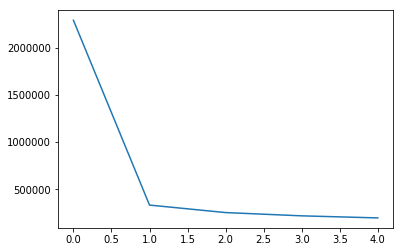

In [39]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

#### overall accuracy

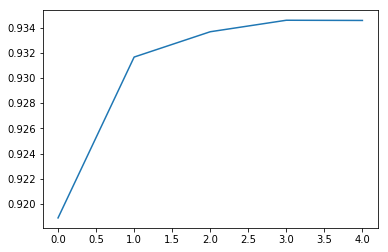

In [40]:
import matplotlib.pyplot as plt
plt.plot(overall_accs)
plt.show()

#### sentence accuracy

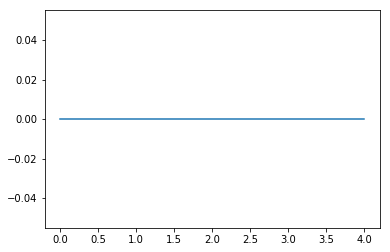

In [41]:
import matplotlib.pyplot as plt
plt.plot(sentence_accs)
plt.show()